In [1]:
!pip install --upgrade --force-reinstall box2d-py
!pip install --upgrade --force-reinstall gym[Box_2D]

     |████████████████████████████████| 450kB 5.2MB/s 
     |████████████████████████████████| 1.6MB 4.5MB/s 
     |████████████████████████████████| 27.4MB 141kB/s 
     |████████████████████████████████| 15.3MB 145kB/s 
     |████████████████████████████████| 1.0MB 36.1MB/s 
     |████████████████████████████████| 2.2MB 47.8MB/s 
     |████████████████████████████████| 829kB 32.6MB/s 
  Created wheel for gym: filename=gym-0.18.0-cp37-none-any.whl size=1656447 sha256=906a646dacf40b52cb5b8865da6ef7c1263ce7675a7807988e2574b7a1e6e50a
  Stored in directory: /root/.cache/pip/wheels/be/85/3b/480b828a4a697b37392740a040b8989f729d952b4e441a1877
  Created wheel for future: filename=future-0.18.2-cp37-none-any.whl size=491058 sha256=34de964cb635863e37240a3936e96eb5c40bf55c3484de6db806b3867a163714
  Stored in directory: /root/.cache/pip/wheels/8b/99/a0/81daf51dcd359a9377b110a8a886b3895921802d2fc1b2397e
Successfully built gym future
ERROR: tensorflow 2.4.1 has requirement numpy~=1.19.2, but you'll

In [109]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.distributions.normal as tdn
import numpy as np
import gym
import matplotlib.pyplot as plt
from datetime import datetime
from google.colab import files
import pandas as pd

In [110]:
def normal_pdf(x,mu,sigma):
    dist = tdn.Normal(loc=mu, scale=torch.sqrt(sigma))
    return dist.log_prob(x).exp()

In [111]:
class actor(nn.Module):
    def __init__(self, input_shape, output_shape):
        super(actor, self).__init__()
        self.inputs = nn.Linear(input_shape, 512)
        self.input_activation = nn.ReLU()
        self.input_mean = nn.Linear(512, 256)
        self.output_mean = nn.Linear(256, output_shape)
        self.actor_mean = nn.Tanh()
        self.input_sigma = nn.Linear(512, 256)
        self.output_sigma = nn.Linear(256, output_shape)
        self.actor_sigma = nn.Sigmoid()

    def forward(self, x):
        lvl1 = self.inputs(x)
        lvl1 = self.input_activation(lvl1)

        means = self.input_mean(lvl1)
        means = self.input_activation(means)
        means = self.output_mean(means)
        means = self.actor_mean(means)

        sigmas = self.input_sigma(lvl1)
        sigmas = self.input_activation(sigmas)
        sigmas = self.output_sigma(sigmas)
        sigmas = self.actor_sigma(sigmas)
        return means, sigmas


class critic(nn.Module):
    def __init__(self, input_shape, output_shape):
        super(critic, self).__init__()

        self.inputs = nn.Linear(input_shape, 512)
        self.input_activation = nn.ReLU()
        self.layers = nn.Linear(512, 256)
        self.output = nn.Linear(256, output_shape)

    def forward(self, x):
        lvl = self.inputs(x)
        lvl = self.input_activation(lvl)
        lvl = self.layers(lvl)
        lvl = self.input_activation(lvl)
        outputs = self.output(lvl)
        return outputs


In [112]:
problem = "LunarLanderContinuous-v2"
RANDOM_SEEDS = 123
gym_env = gym.make(problem)
gym_env.seed(RANDOM_SEEDS)

gym_env.reset()

max_episodes = 2000
gamma = 0.99
state_shape = gym_env.observation_space.shape[0]
action_dim = gym_env.action_space.shape[0]
upper_bound = gym_env.action_space.high[0]
lower_bound = gym_env.action_space.low[0]
epsilon=0.2
n_updates=10 
lr_critic=1e-3
lr_actor=1e-5
memory_size=2**14

now = datetime.now()
date_time = now.strftime("%Y%m%d_%H%M%S")

In [113]:
ep_reward_list = []
ep_steps_list = []
avg_reward_list = []

In [114]:
actor_model = actor(state_shape, action_dim)
critic_model = critic(state_shape, 1)
optimizer_actor = optim.Adam(actor_model.parameters(), lr=lr_actor)
optimizer_critic = optim.Adam(critic_model.parameters(), lr=lr_critic)

Episode * 0 * Steps 94  * Episodic Reward is ==> -310.2798248389545 * Lastest 100 Episods Avg Reward is ==> -310.2798248389545
Episode * 10 * Steps 114  * Episodic Reward is ==> -171.72374728082542 * Lastest 100 Episods Avg Reward is ==> -347.08232283336446
Episode * 20 * Steps 133  * Episodic Reward is ==> -200.13852391205637 * Lastest 100 Episods Avg Reward is ==> -308.97448301480273
Episode * 30 * Steps 84  * Episodic Reward is ==> -60.007735890590624 * Lastest 100 Episods Avg Reward is ==> -275.51148118687735
Episode * 40 * Steps 82  * Episodic Reward is ==> -80.33173301822221 * Lastest 100 Episods Avg Reward is ==> -240.64257504611234
Episode * 50 * Steps 74  * Episodic Reward is ==> -108.78616472707387 * Lastest 100 Episods Avg Reward is ==> -231.37195667826984
Episode * 60 * Steps 114  * Episodic Reward is ==> -96.92484207713721 * Lastest 100 Episods Avg Reward is ==> -212.83053266715098
Episode * 70 * Steps 83  * Episodic Reward is ==> -159.5651626834253 * Lastest 100 Episods A

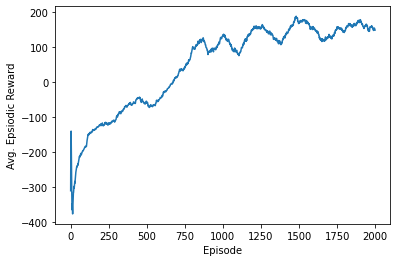

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [115]:
for ep in range(max_episodes):
    buffer = ReplayBuffer(memory_size=memory_size)
    episodic_reward = 0
    state = gym_env.reset()
    done = False
    steps = 0
    gaes = []
    states = []
    actions = []

    while not done:
        with torch.no_grad():
            states.append(state)
            mu, var = actor_model(torch.tensor(state))
            mu = mu.detach().numpy()
            std_dev = torch.sqrt(var).detach().numpy()
            action = np.clip(np.random.normal(mu, std_dev), lower_bound, upper_bound).flatten()
            actions.append(action)
        
        next_state, reward, done, info = gym_env.step(action)
        gaes.append(reward)
        if len(gaes)>1:
            for i in range(len(gaes)-1):
                gaes[i]+=(gamma**(steps-i))*reward

        episodic_reward += reward
        state = next_state
        steps+=1
    gaes = torch.tensor(gaes, dtype=torch.float32)
    states = torch.tensor(states, dtype=torch.float32)
    actions = torch.tensor(actions, dtype=torch.float32)

    values = critic_model(states)
    values = torch.reshape(values,gaes.shape)
    psi = gaes - values.detach()
    means, sigmas = actor_model(states)
    dist_v1 = normal_pdf(actions[:,0], means[:,0], sigmas[:,0])
    dist_v2 = normal_pdf(actions[:,1], means[:,1], sigmas[:,1])
    pi = dist_v1 * dist_v2
    old_pi = pi.detach()

    for n in range(n_updates):
        critic_model.train()
        values = critic_model(states)
        values = torch.reshape(values,gaes.shape)
        means, sigmas = actor_model(states)
        dist_v1 = normal_pdf(actions[:,0], means[:,0], sigmas[:,0])
        dist_v2 = normal_pdf(actions[:,1], means[:,1], sigmas[:,1])
        pi = dist_v1 * dist_v2
        critic_loss = nn.functional.mse_loss(values, gaes.detach())
        optimizer_critic.zero_grad()
        critic_loss.backward()
        nn.utils.clip_grad_norm_(critic_model.parameters(), max_norm=1.0)
        optimizer_critic.step()
        r = torch.div(pi, old_pi)
        c_eps = torch.max(torch.min(r, torch.tensor(1+epsilon, dtype=torch.float32)), torch.tensor(1-epsilon, dtype=torch.float32))
        psi = psi.detach()
        actor_model.train()
        actor_loss = -torch.mean(torch.min(r*psi,c_eps*psi))
        optimizer_actor.zero_grad()
        actor_loss.backward()
        nn.utils.clip_grad_norm_(actor_model.parameters(), max_norm=1.0)
        optimizer_actor.step()

    ep_reward_list.append(episodic_reward)
    ep_steps_list.append(steps)
    avg_reward = np.mean(ep_reward_list[-100:])
    avg_reward_list.append(avg_reward)
    
    if ep%10 == 0:
        print(f"Episode * {ep} * Steps {steps}  * Episodic Reward is ==> {episodic_reward} * Lastest 100 Episods Avg Reward is ==> {avg_reward}")

plt.plot(avg_reward_list)
plt.xlabel("Episode")
plt.ylabel("Avg. Epsiodic Reward")
plt.show()

content = {"ep_reward":ep_reward_list,"avg_reward":avg_reward_list, "steps":ep_steps_list}
df = pd.DataFrame(content)
df.to_csv(f'ppo_{date_time}.csv') 
files.download(f'ppo_{date_time}.csv')

def normal_density(x, mu, sigma):
    factor= 1./(torch.sqrt(2*np.pi*sigma))
    expo = torch.exp(-((x-mu)**2)/(2*sigma))
    return factor*expo